              model  cv_MAE_mean  cv_MAE_std  cv_RMSE_mean  cv_RMSE_std  \
0      RandomForest    56.708723    3.737169    107.653787    24.842325   
1  GradientBoosting    58.191558    3.520719    110.792771    25.254819   
2               KNN    60.669297    3.802720    112.551555    23.327154   
3             Ridge    61.338706    3.887792    110.557385    24.906474   
4             Lasso    61.391296    3.920995    110.624115    24.870048   
5  LinearRegression    61.550838    3.876998    110.740611    24.754928   
6  Baseline(median)    84.707113    0.000000    135.390792     0.000000   

   cv_R2_mean  cv_R2_std                                        best_params  
0    0.338018   0.090170  {'max_depth': 10, 'min_samples_leaf': 5, 'n_es...  
1    0.296287   0.114688  {'learning_rate': 0.03, 'max_depth': 3, 'n_est...  
2    0.270763   0.094635         {'n_neighbors': 20, 'weights': 'distance'}  
3    0.302066   0.077027                                    {'alpha': 10.0}  
4    0.30

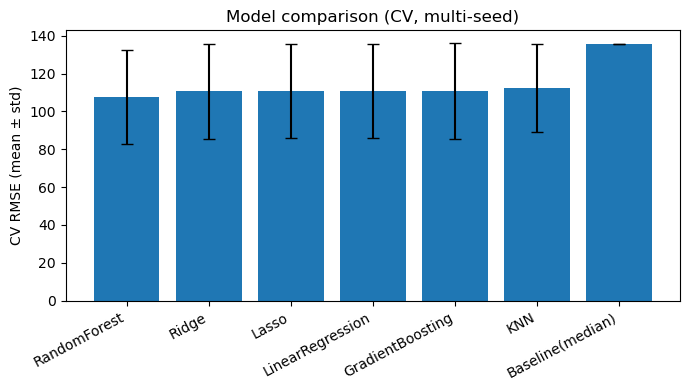

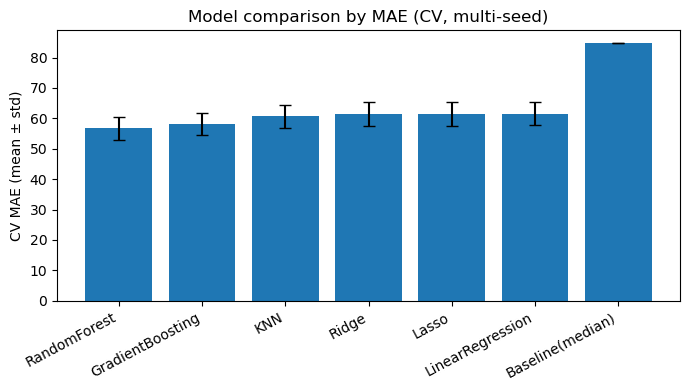

In [8]:
import warnings, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

ROOT = Path('..')
RES  = ROOT / 'results'
FIGS = ROOT / 'figures'
RES.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)
FIG_DPI = 300

X_train = np.load(RES/'X_train.npy'); y_train = np.load(RES/'y_train.npy')
X_val   = np.load(RES/'X_val.npy');   y_val   = np.load(RES/'y_val.npy')
X_test  = np.load(RES/'X_test.npy');  y_test  = np.load(RES/'y_test.npy')

with open(RES/'feature_names.json','r', encoding='utf-8') as f:
    feature_names = json.load(f)

X_tr = np.vstack([X_train, X_val])
y_tr = np.concatenate([y_train, y_val])

warnings.filterwarnings("ignore", category=UserWarning)

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

y_med = float(np.median(y_tr))
rows = [{
    "model":        "Baseline(median)",
    "cv_MAE_mean":  float(mean_absolute_error(y_tr, np.repeat(y_med, len(y_tr)))),
    "cv_MAE_std":   0.0,
    "cv_RMSE_mean": float(rmse(y_tr, np.repeat(y_med, len(y_tr)))),
    "cv_RMSE_std":  0.0,
    "cv_R2_mean":   0.0,
    "cv_R2_std":    0.0,
    "best_params":  {}
}]

PRIMARY_SEED = 42

model_specs = [
    ("LinearRegression",
     LinearRegression(),
     {"fit_intercept": [True]}),

    ("Ridge",
     Ridge(),
     {"alpha": [0.1, 1.0, 10.0, 100.0]}),

    ("Lasso",
     Lasso(max_iter=20000),
     {"alpha": [0.001, 0.01, 0.1, 1.0]}),

    ("RandomForest",
     RandomForestRegressor(n_jobs=-1, random_state=PRIMARY_SEED),
     {"n_estimators": [300],
      "max_depth": [4, 6, 8, 10],
      "min_samples_leaf": [2, 5, 10]}),

    ("GradientBoosting",
     GradientBoostingRegressor(random_state=PRIMARY_SEED),
     {"n_estimators": [200, 400],
      "learning_rate": [0.03, 0.1],
      "max_depth": [2, 3]}),

    ("KNN",
     KNeighborsRegressor(),
     {"n_neighbors": [5, 10, 20],
      "weights": ["uniform", "distance"]}),
]

kfold_primary = KFold(n_splits=5, shuffle=True, random_state=PRIMARY_SEED)

model_best = {}
for name, est, grid in model_specs:
    g = GridSearchCV(
        estimator=clone(est),
        param_grid=grid,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        cv=kfold_primary,
        refit=True,
        verbose=0
    )
    g.fit(X_tr, y_tr)
    model_best[name] = (g.best_estimator_, g.best_params_)

SEEDS = [0, 1, 2, 3, 4]

def set_seed_if_supported(estimator, seed):
    est = clone(estimator)
    if hasattr(est, "random_state"):
        est.random_state = seed
    return est

for name in [n for n, _, _ in model_specs]:
    best_est, best_params = model_best[name]

    mae_all, rmse_all, r2_all = [], [], []
    for s in SEEDS:
        kf = KFold(n_splits=5, shuffle=True, random_state=s)
        est_seeded = set_seed_if_supported(best_est, s)

        neg_mae = cross_val_score(est_seeded, X_tr, y_tr,
                                  scoring="neg_mean_absolute_error",
                                  cv=kf, n_jobs=-1)
        neg_mse = cross_val_score(est_seeded, X_tr, y_tr,
                                  scoring="neg_mean_squared_error",
                                  cv=kf, n_jobs=-1)
        r2_sc   = cross_val_score(est_seeded, X_tr, y_tr,
                                  scoring="r2",
                                  cv=kf, n_jobs=-1)

        mae_all.extend(-neg_mae)
        rmse_all.extend(np.sqrt(-neg_mse))
        r2_all.extend(r2_sc)

    rows.append({
        "model":        name,
        "cv_MAE_mean":  float(np.mean(mae_all)),
        "cv_MAE_std":   float(np.std(mae_all,  ddof=1)),
        "cv_RMSE_mean": float(np.mean(rmse_all)),
        "cv_RMSE_std":  float(np.std(rmse_all, ddof=1)),
        "cv_R2_mean":   float(np.mean(r2_all)),
        "cv_R2_std":    float(np.std(r2_all,   ddof=1)),
        "best_params":  best_params
    })

df_scores = pd.DataFrame(rows)
df_sorted_mae  = df_scores.sort_values('cv_MAE_mean',  ascending=True).reset_index(drop=True)
df_sorted_rmse = df_scores.sort_values('cv_RMSE_mean', ascending=True).reset_index(drop=True)

df_scores.to_csv(RES/'model_scores_cv_multi_seed.csv', index=False)
print(df_sorted_mae)

best_name = df_sorted_mae.iloc[0]['model']
if best_name == "Baseline(median)" and len(df_sorted_mae) > 1:
    best_name = df_sorted_mae.iloc[1]['model']

best_est, best_params = model_best[best_name]
best_est = set_seed_if_supported(best_est, PRIMARY_SEED)
best_est.fit(X_tr, y_tr)

y_pred_test = best_est.predict(X_test)
test_mae  = float(mean_absolute_error(y_test, y_pred_test))
test_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred_test)))
test_r2   = float(r2_score(y_test, y_pred_test))

pd.DataFrame([{
    "best_model":  best_name,
    "test_MAE":    test_mae,
    "test_RMSE":   test_rmse,
    "test_R2":     test_r2,
    "best_params": best_params
}]).to_csv(RES/'best_model_test_scores.csv', index=False)

print(f"\nBest(by MAE): {best_name} | TEST -> MAE: {test_mae:.2f}  RMSE: {test_rmse:.2f}  R2: {test_r2:.3f}")

plt.figure(figsize=(7,4))
order = df_sorted_rmse['model'].tolist()
means = df_sorted_rmse.set_index('model').loc[order, 'cv_RMSE_mean'].to_numpy(dtype=float)
errs  = df_sorted_rmse.set_index('model').loc[order, 'cv_RMSE_std' ].to_numpy(dtype=float)
plt.bar(order, means, yerr=errs, capsize=4)
plt.ylabel('CV RMSE (mean ± std)')
plt.xticks(rotation=28, ha='right')
plt.title('Model comparison (CV, multi-seed)')
plt.tight_layout()
plt.savefig(FIGS/'fig_model_scores_rmse.png', dpi=FIG_DPI)
plt.show()

plt.figure(figsize=(7,4))
order_mae = df_sorted_mae['model'].tolist()
means_mae = df_sorted_mae.set_index('model').loc[order_mae, 'cv_MAE_mean'].to_numpy(dtype=float)
errs_mae  = df_sorted_mae.set_index('model').loc[order_mae, 'cv_MAE_std' ].to_numpy(dtype=float)
plt.bar(order_mae, means_mae, yerr=errs_mae, capsize=4)
plt.ylabel('CV MAE (mean ± std)')
plt.xticks(rotation=28, ha='right')
plt.title('Model comparison by MAE (CV, multi-seed)')
plt.tight_layout()
plt.savefig(FIGS/'fig_model_scores_mae.png', dpi=FIG_DPI)
plt.show()